<a href="https://colab.research.google.com/github/LasZAAU/AAU/blob/master/Copy_of_M2_eksam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# M2 Eksamen

## Description of data acquisition / how it was collected (by you or the publisher of the data)

The dataset is a set of SMS labeled messages which is collected for mobile phone spam research. The dataset is a collection of 5.574 real and non-enconded English messages. 
The dataset is a collection of various free research content on the Internet. For example, some of the spam messages come from a UK forum where you can report if the messages is spam. Additionally, some of ham messages are getting from the Institute of Computer Science at the National University of Singapore. All the messages is incorporated to our dateset " SMS Spam Collection."


## Definition of a problem statement and a short outline of the implementation

This project will be centralized around SMS messages and how Data Science can contribute to filtering out unwanted text messages. The overall problem is affiliated with the different types of SMS labeled messages with specific focus on "Spam" in SMS messages. Spam is generally associated with messages that contain advertisement, harrestment or general fraud. Spam messages often contain hidden links, with the intent of obtaining the users password,login informaton, bank information or credit card informartion. Spam messages are an extreme nuisance for the general population, which creates a clear problem concerning detecting these spam SMS messages. The overall goal of this project will be to discover how spam SMS messages differ from ordinary messages, so a proper model can be made for detecting and filtering out spam messages. This will done by firstly analyzing the messages and discovering topic detection throughout all the messages.****(skal vi skrive alt hvad vi gør eller ikke? hvad synes i?)


## Data preparation (general)

We load the majority of the packages needed for the analysis

In [1]:
install.packages("pacman")
library(pacman)
pacman::p_load(tidyverse,
               magrittr,
               SnowballC,
               corpus,
               quanteda,
               tidytext,
               tm,
               topicmodels,
               lsa,
               uwot, #for UMAP
               dbscan,# For density based clustering
               ggraph,
               igraph,
               text2vec,
               randomForest
              )

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

SnowballC installed
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

corpus installed
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependencies ‘coda’, ‘extrafontdb’, ‘Rttf2pt1’, ‘RcppEigen’, ‘statnet.common’, ‘reticulate’, ‘ISOcodes’, ‘data.table’, ‘extrafont’, ‘fastmatch’, ‘ggrepel’, ‘network’, ‘RSpectra’, ‘RcppParallel’, ‘sna’, ‘spacyr’, ‘stopwords’, ‘proxyC’, ‘RcppArmadillo’


quanteda installed
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependencies ‘hunspell’, ‘tokenizers’, ‘janeaustenr’


tidytext installed
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependencies ‘NLP’, ‘slam’


tm installed
Installing package in

In [2]:
SMSspam=read_delim("https://raw.githubusercontent.com/apla14/hello-world/master/SpamSms", 
    ";",escape_double = FALSE, col_names = FALSE, 
    trim_ws = TRUE)

Parsed with column specification:
cols(
  X1 = col_character(),
  X2 = col_character()
)
Warning message:
“7 parsing failures.
 row col  expected     actual                                                                  file
1129  -- 2 columns 3 columns  'https://raw.githubusercontent.com/apla14/hello-world/master/SpamSms'
1442  -- 2 columns 3 columns  'https://raw.githubusercontent.com/apla14/hello-world/master/SpamSms'
2371  -- 2 columns 3 columns  'https://raw.githubusercontent.com/apla14/hello-world/master/SpamSms'
2435  -- 2 columns 15 columns 'https://raw.githubusercontent.com/apla14/hello-world/master/SpamSms'
3053  -- 2 columns 3 columns  'https://raw.githubusercontent.com/apla14/hello-world/master/SpamSms'
.... ... ......... .......... .....................................................................
See problems(...) for more details.
”

Firstly we inspect the data

In [3]:
SMSspam %>% head()

X1,X2
<chr>,<chr>
ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
ham,Ok lar... Joking wif u oni...
spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
ham,U dun say so early hor... U c already then say...
ham,"Nah I don't think he goes to usf, he lives around here though"
spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv"


We can observe two columns. One indicating whether a SMS is ham(a real legitimate message) or spam(advertising/harassment) and a second column showing the actual text message. These two columns are unnamed in the original dataset, so we add the column names accordingly below

In [4]:
SMSspam %<>% mutate(ID=rownames(SMSspam)) %>% select(ID,X1,X2) 
SMSspam %<>% mutate(ham_spam=X1) %>% mutate(SMS=X2) %>% select(-X1,-X2)
SMSspam %>% head()

ID,ham_spam,SMS
<chr>,<chr>,<chr>
1,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
2,ham,Ok lar... Joking wif u oni...
3,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
4,ham,U dun say so early hor... U c already then say...
5,ham,"Nah I don't think he goes to usf, he lives around here though"
6,spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv"


In [5]:
data = SMSspam %>% unnest_tokens(word,SMS)
data %>% head()
data %>% group_by(word) %>% count() %>% arrange(desc(n)) %>% head()

ID,ham_spam,word
<chr>,<chr>,<chr>
1,ham,go
1,ham,until
1,ham,jurong
1,ham,point
1,ham,crazy
1,ham,available


word,n
<chr>,<int>
i,2300
to,2249
you,2149
a,1448
the,1335
u,1183


In [6]:
own_stopwords = tibble(word = c("gt","lt","ü","2","4"), lexicon="OWN")
data= data %>% anti_join(stop_words%>% bind_rows(own_stopwords),by="word") %>% mutate(word=wordStem(word))
data %>% group_by(word) %>% count() %>% arrange(desc(n)) %>% head()

word,n
<chr>,<int>
call,673
ur,395
free,282
dai,261
love,258
time,249


In [7]:
dtm = data %>%  count(ID, word) %>% cast_dtm(document =ID, term = word, value = n, weighting = tm::weightTf)

dtm

dtm %>% removeSparseTerms(sparse = .99)
dtm %>% removeSparseTerms(sparse = .999)
dtm %>% removeSparseTerms(sparse = .9999)

<<DocumentTermMatrix (documents: 5451, terms: 7417)>>
Non-/sparse entries: 35192/40394875
Sparsity           : 100%
Maximal term length: 42
Weighting          : term frequency (tf)

<<DocumentTermMatrix (documents: 5451, terms: 78)>>
Non-/sparse entries: 8497/416681
Sparsity           : 98%
Maximal term length: 8
Weighting          : term frequency (tf)

<<DocumentTermMatrix (documents: 5451, terms: 1159)>>
Non-/sparse entries: 24917/6292792
Sparsity           : 100%
Maximal term length: 17
Weighting          : term frequency (tf)

<<DocumentTermMatrix (documents: 5451, terms: 7417)>>
Non-/sparse entries: 35192/40394875
Sparsity           : 100%
Maximal term length: 42
Weighting          : term frequency (tf)

## Network Data - preparation

MANGLER

## NLP - preparation

..

## Network analysis





..


# NLP
- EDA / simple frequency-based analysis
- Simple vectorization (BoW, Tf-idf)
- Topic modelling / Clustering (LDA / LSA)
- Embedding-model based vectorization (Word2Vec, Fasttext, GloVe)

Tf-idf which stands for term-frequency- inverse document frequency, measures how relevant a term is in given document and how often a words appear. The relevans of the word increase to the number of times a word appears, but is offset by the frequency of the word in the corpus.

In [8]:
sms_idf <- data %>% 
  count(ham_spam,word, sort = TRUE) %>% 
  bind_tf_idf(ham_spam, word, n)

sms_idf %>% 
  head()

ham_spam,word,n,tf,idf,tf_idf
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
spam,call,379,0.5631501,1.1015829,0.6203565
ham,call,294,0.4368499,0.2615556,0.1142606
ham,ur,251,0.6354430,0.2615556,0.1662037
ham,love,248,0.9612403,0.2615556,0.2514178
ham,time,230,0.9236948,0.2615556,0.2415976
ham,dai,229,0.8773946,0.2615556,0.2294875


*TF:* Term frequency of a word shows how frequently words appear. If the document is long, then it is possible that a word would appear much more times than shorter ones. TF is intended thus: 
- TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document). 

The figure shows that 'call' appears 379 times in spam and 294 times in ham. The term frequency for call is respectively 0.56 and 0.43.






*IDF:* Inverse document frequency shows how common or rare a word is in the document. If IDF is closer to 0, then the word is more common and if not then it will approach to 1. IDF can be calculated: 
- (the total number of documents/number of documents that contain a word and calculating the logarith). 

When we multiply the numbers for TF and IDF it gives TD-IDF score. If the score is high the more relevant is the word in the document.  





In [9]:
sms_idf %>% 
arrange(desc(tf_idf))  %>% 
head()
  

ham_spam,word,n,tf,idf,tf_idf
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
spam,claim,115,1,1.101583,1.101583
spam,prize,94,1,1.101583,1.101583
spam,tone,85,1,1.101583,1.101583
spam,won,73,1,1.101583,1.101583
spam,150p,71,1,1.101583,1.101583
spam,guarante,51,1,1.101583,1.101583


In [10]:
#document - feature - matrix 
sms_dfm <-data %>%
count(ID, word) %>%
cast_dfm(document =ID, term =word, value =n)
sparse = Matrix::Matrix(sms_dfm,sparse = TRUE)

sms_dfm

#When the document-feature-matrix is created, we execute a LDA with the quanteda function textmodel_lsa():
sms_lsa <-sms_dfm %>%
textmodel_lsa(nd =5)
sms_lsa %>% glimpse()

sms_lsa_loading <-sms_lsa$docs %>%as.data.frame() %>%rownames_to_column(var ="ID") %>%as_tibble()
sms_lsa_loading %>%head()



Document-feature matrix of: 5,451 documents, 7,417 features (99.9% sparse).

List of 5
 $ sk             : num [1:5] 34.2 28.1 23.7 22.8 20
 $ docs           : num [1:5451, 1:5] -1.19e-03 -5.87e-02 -1.45e-04 -1.40e-02 -7.51e-05 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:5451] "1" "10" "100" "1000" ...
  .. ..$ : NULL
 $ features       : num [1:7417, 1:5] -3.47e-05 -4.41e-05 -6.82e-04 -4.93e-04 -4.50e-03 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:7417] "amor" "buffet" "bugi" "cine" ...
  .. ..$ : NULL
 $ matrix_low_rank: num [1:5451, 1:7417] 1.96e-05 -1.30e-04 1.18e-06 9.50e-05 6.22e-07 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:5451] "1" "10" "100" "1000" ...
  .. ..$ : chr [1:7417] "amor" "buffet" "bugi" "cine" ...
 $ data           :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. ..@ i       : int [1:35192] 0 0 3160 0 383 715 1141 1841 2673 4409 ...
  .. ..@ p       : int [1:7418] 0 1 3 10 17 31 32 39 140 175 ...
  .. ..@ Dim     : int [1:2] 5451 7417
  .. ..@ Dimnames:List of 2
  .. ..@ x       : num

ID,V1,V2,V3,V4,V5
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-1.187007e-03,2.126374e-03,2.119954e-03,-0.0004722118,0.0029940137
10,-5.872433e-02,-1.667147e-02,-4.954157e-02,0.0405215259,-0.0132345199
100,-1.454873e-04,6.120718e-05,-4.932348e-05,0.0003372846,0.0003795642
1000,-1.400165e-02,2.884178e-02,1.434156e-03,-0.0129542770,0.0026251357
1001,-7.513273e-05,1.541918e-05,-6.718202e-05,0.0002223929,0.0002496870
1002,-3.079406e-04,3.845725e-04,2.661723e-04,-0.0001671042,0.0006136200


The dimensionality reduction can be visualized using the UMAP function.




In [11]:
sms_lsa_umap <- umap(sms_lsa_loading %>% column_to_rownames("ID"), 
                       n_neighbors = 15, metric = "cosine", min_dist = 0.01, scale = TRUE,
                       verbose = TRUE, n_threads = 8) 

11:53:23 UMAP embedding parameters a = 1.896 b = 0.8006
11:53:23 Read 5451 rows and found 5 numeric columns
11:53:23 Scaling to zero mean and unit variance
11:53:23 Kept 5 non-zero-variance columns
11:53:23 Using Annoy for neighbor search, n_neighbors = 15
11:53:24 Building Annoy index with metric = cosine, n_trees = 50
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
11:53:26 Writing NN index file to temp file /tmp/Rtmp4eUQOO/file7b71d955fa
11:53:26 Searching Annoy index using 8 threads, search_k = 1500
11:53:27 Annoy recall = 98%
11:53:28 Commencing smooth kNN distance calibration using 8 threads
11:53:28 377 smooth knn distance failures
11:53:28 Initializing from normalized Laplacian + noise
11:53:29 Commencing optimization for 500 epochs, with 100358 positive edges
11:53:40 Optimization finished


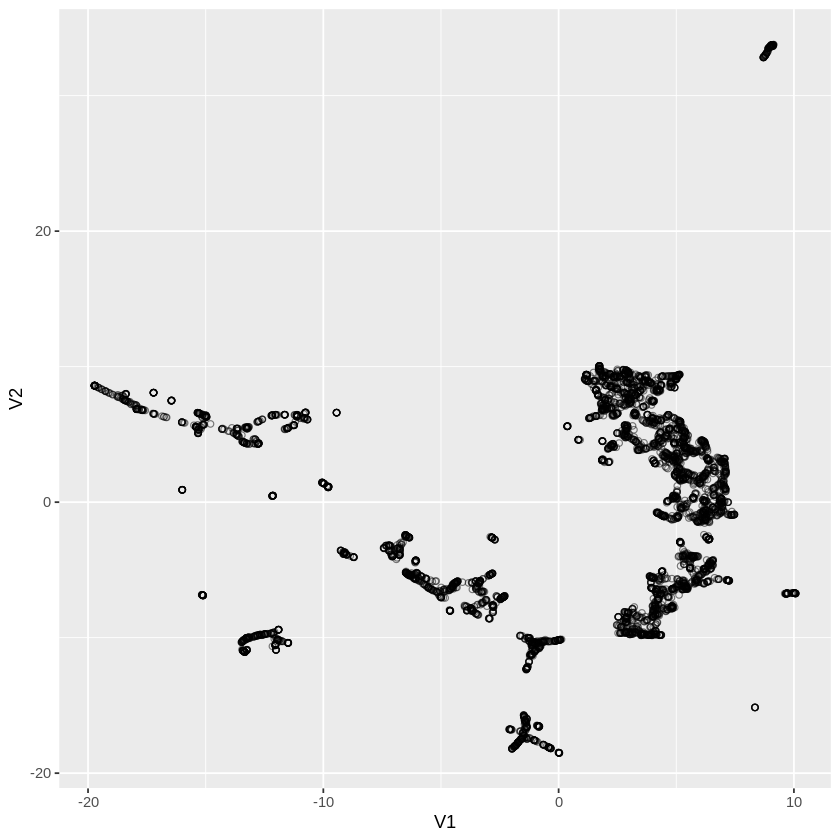

In [12]:
sms_lsa_umap %<>% as.data.frame()
sms_lsa_umap %>% 
  ggplot(aes(x = V1, y = V2)) + 
  geom_point(shape = 21, alpha = 0.5) 








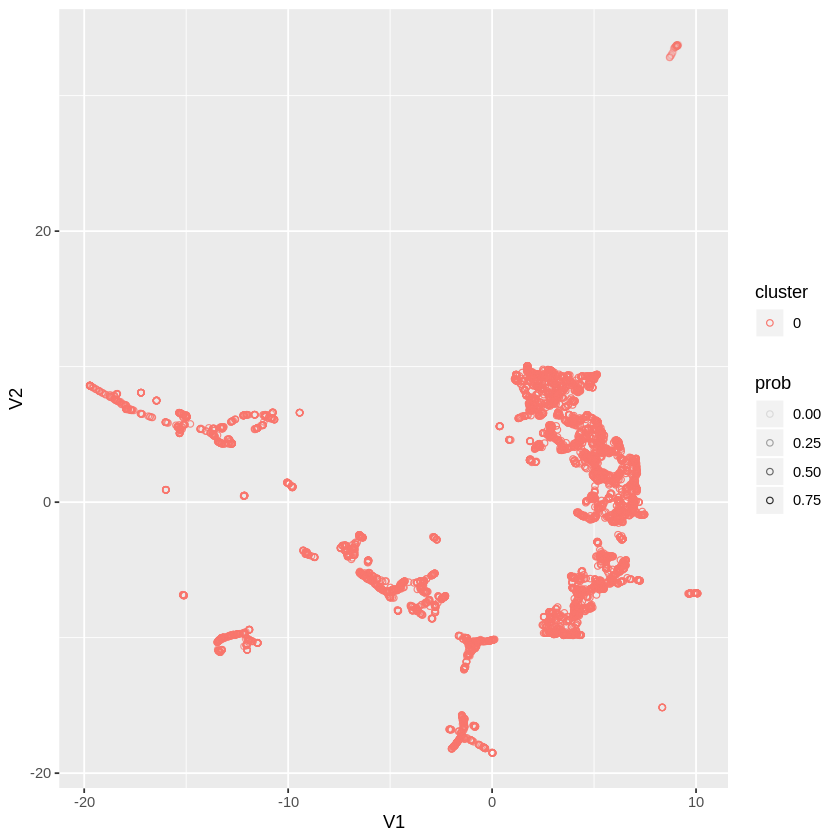

In [13]:
lsa_hdbscan <- sms_lsa_umap %>% as.matrix() %>% hdbscan(minPts = 500)

sms_lsa_umap %>%
  bind_cols(cluster = lsa_hdbscan$cluster %>% as.factor(),
            prob = lsa_hdbscan$membership_prob) %>%
  ggplot(aes(x = V1, y = V2, col = cluster)) +
  geom_point(aes(alpha = prob), shape = 21) 

# GLOVE

In [14]:
sms_corpus <- data %>% corpus(docid_field = "ID", text_field = "word")
sms_corpus
sms_toks <- tokens(sms_corpus, what = "word") %>%
  tokens_tolower() %>%
  tokens(remove_punct = TRUE,
         remove_symbols = TRUE,
        remove_numbers = TRUE,
         remove_url = TRUE,
         remove_separators = TRUE,
         remove_hyphens = TRUE )

feats <- dfm(sms_toks, verbose = TRUE) %>%
  dfm_trim(min_termfreq = 5) %>%
  featnames()


sms_fcm <- fcm(sms_toks, 
                 context = "window", 
                 count = "weighted", 
                 weights = 1 / (1:5), 
                 tri = TRUE)








Warning message:
“'[[.corpus' is deprecated.
Use 'docvars' instead.
See help("Deprecated")”Warning message:
“'[[.corpus' is deprecated.
Use 'docvars' instead.
See help("Deprecated")”Warning message:
“'[[.corpus' is deprecated.
Use 'docvars' instead.
See help("Deprecated")”ERROR while rich displaying an object: Error in `[.data.frame`(x$documents, i, ...): undefined columns selected

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .        

Corpus consisting of 37,028 documents and 1 docvar.

Creating a dfm from a tokens input...
   ... lowercasing
   ... found 37,028 documents, 6,795 features
   ... created a 37,028 x 6,795 sparse dfm
   ... complete. 
Elapsed time: 0.112 seconds.


In [0]:
glove <- GlobalVectors$new(word_vectors_size = 50, vocabulary = featnames(sms_fcm), x_max = 10)
sms_word_vectors <- fit_transform(sms_fcm, glove, n_iter = 0.90)

In [0]:
sms_word_vectors %<>% as.data.frame() %>%
  rownames_to_column(var = "word") %>% 
  as_tibble()


In [17]:
sms_word_vectors %>% head()

word,V1,V2,V3,V4,V5,V6,V7,V8,V9,⋯,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
jurong,-0.25437078,-0.07510546,0.1610151,-0.007400527,-0.186215445,0.37266535,0.05508992,-0.05834907,-0.221634760,⋯,0.2235631,0.12294930,-0.3150425,-0.1955347,-0.40406820,0.45834967,0.09548289,0.32235420,0.3094678,0.41186592
crazi,0.07572033,-0.14359562,-0.2596721,-0.327485412,0.046596766,-0.20204933,0.19173227,-0.06947790,0.004112659,⋯,-0.2693185,-0.44963560,0.2956448,0.2456707,0.15092823,0.03527993,-0.01917049,-0.49490604,0.3842939,-0.25377664
bugi,-0.17439535,-0.16559309,-0.3670309,0.001198952,-0.357650161,0.17671950,0.33942410,0.45690334,-0.449809641,⋯,-0.4212098,0.01610508,-0.4956923,0.3026210,-0.30883127,0.36440337,0.23972128,0.20294061,0.3330303,0.01262574
world,0.14749026,-0.48409262,-0.2858688,0.154734373,0.411302745,-0.33810228,-0.14768428,-0.33317426,-0.479534179,⋯,-0.1746077,0.42417276,-0.1118214,0.2445628,-0.26617247,-0.03996330,0.44077295,-0.11049783,-0.2414070,0.47678185
la,-0.07439323,-0.49457532,0.1135033,-0.415027738,-0.466333270,0.09332709,-0.31998470,-0.31652245,-0.472731471,⋯,0.4572858,-0.10330486,0.3993714,-0.2516550,-0.19140580,-0.03114243,-0.21858446,0.06851213,0.1554995,0.37878606
buffet,-0.24009825,-0.42984524,0.3498144,0.085171357,-0.002180582,0.18949229,-0.35383749,0.49486953,0.310745090,⋯,0.2529903,-0.49568519,0.1054294,0.3868899,-0.00496874,-0.10110723,0.14349030,0.26020548,0.1203069,-0.07930529


# -----------------------

# LSA

In [18]:
pacman::p_load(text2vec,topicmodels)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Warning message in utils::install.packages(package, ...):
“installation of package ‘topicmodels’ had non-zero exit status”Warning message in p_install(package, character.only = TRUE, ...):
“”Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘topicmodels’”Warning message in pacman::p_load(text2vec, topicmodels):
“Failed to install/load:
topicmodels”

In [19]:
lda = sparse %>%   LDA(k = 2, method = "Gibbs", control = list(seed = 1337))


lda_beta <- lda %>%
  tidy(matrix = "beta") %>%
  group_by(topic) %>%
  arrange(topic, desc(beta)) %>%
  slice(1:10) %>%
  ungroup()

lda_beta %>% head()

lda_beta %>%
  mutate(term = reorder_within(term, beta, topic)) %>%
  group_by(topic, term) %>%
  arrange(desc(beta)) %>%
  ungroup() %>%
  ggplot(aes(term, beta, fill = as.factor(topic))) +
  geom_col(show.legend = FALSE) +
  coord_flip() +
  scale_x_reordered() +
  labs(title = "Top 10 terms in each LDA topic",
       x = NULL, y = expression(beta)) +
  facet_wrap(~ topic, ncol = 2, scales = "free")

ERROR: ignored

## Supervised / Unsupervised ML

After making a dimensionality reduction with a corresponding train and test set, it is now time to construct models to predict whether a message is "ham" or "spam". The models will use the value of each word from the dimensionality reduction matrix to determine if a message is spam or not. The first model that will be constructed is a Generalized Linear Model, where the prediction is modeled as a weighted sum of the features. We construct the model below:

After constructing the GLM model, it is time to test the model on the actual test dataset which we created earlier. 

We continue to present the results in an actual confusion matrix to make it more presentable.

GLM seems to be an ineffective model for predicting spam messages versus normal messages. The overall accuracy is 0.69% which is significantly low. The model classified xxx ham messages incorrectly as spam messages and determined xxx spam messages to be ham messages. A better and more suitable model is needed for this type of classification and therefore we try constructing a decision tree model  

After construction the model we test it on the same test dataset and present the results.

Decision Tree appears to be a more accurate and stable model with a high accuracy on 95%. This is significantly better then the previous GLM model and we can observe the model only classified xxx SMS messages incorrectly. Alternatively we could try constructing a random forest model which is a more advanced model compared to the original decision tree. Random forest, like its name implies, consists of a large number of individual decision trees that operate as an ensemble. Each individual tree in the random forest spits out a class prediction and the class with the most votes becomes our model’s prediction. We construct the model below and print out the results

The Random Forest model is the most accurate model with a accuracy on 96.22% beating both the decision tree and GLM model. 

In [0]:
pacman::p_load(caret,irlba)


# Use caret to create a 70%/30% stratified split. Set the random
# seed for reproducibility.
set.seed(32984)
indexes <- createDataPartition(as.factor(SMSspam$ham_spam), times = 1,
                               p = 0.7, list = FALSE)

train <- SMSspam[indexes,]
test <- SMSspam[-indexes,]




In [0]:
train_tokens = tokens(train$SMS, what = "word", 
                remove_numbers = TRUE, remove_punct = TRUE,
                remove_symbols = TRUE, remove_hyphens = TRUE)
train_tokens %>% head()

train_tokens = tokens_tolower(train_tokens)


train_tokens = tokens_select(train_tokens, stopwords(), 
                       selection = "remove")
train_tokens %>% head()

train_tokens = tokens_wordstem(train_tokens, language = "english")

train_tokens %>% head()

train_tokens.dfm <- dfm(train_tokens, tolower = FALSE)
train_tokens.dfm %>% head()

train_tokens.matrix <- as.matrix(train_tokens.dfm)
train_tokens.matrix %>% head()

train_tokens.df <- cbind(Label = train$ham_spam, convert(train_tokens.dfm,to = "data.frame"))
train_tokens.df




In [0]:

train_term.frequency <- function(row) {
  row / sum(row)
}


train_inverse.doc.freq <- function(col) {
  corpus.size <- length(col)
  doc.count <- length(which(col > 0))
  
  log10(corpus.size / doc.count)
}


tf.idf <- function(x, idf) {
  x * idf
}

train_tokens.df <- apply(train_tokens.matrix, 1, train_term.frequency)

train_tokens.idf <- apply(train_tokens.matrix, 2, train_inverse.doc.freq)

train_tokens.tfidf <-  apply(train_tokens.df, 2, tf.idf, idf = train_tokens.idf)

train_tokens.tfidf <- t(train_tokens.tfidf)




In [0]:
train_incomplete.cases <- which(!complete.cases(train_tokens.tfidf))
train$SMS[train_incomplete.cases]

train_tokens.tfidf[train_incomplete.cases,] <- rep(0.0, ncol(train_tokens.tfidf))

train_tokens.tfidf.df <- cbind(Label = train$ham_spam, data.frame(train_tokens.tfidf))

train_tokens <- tokens_ngrams(train_tokens, n = 1:2)

train_irlba <- irlba(t(train_tokens.tfidf), nv = 300, maxit = 600)


train_sigma.inverse <- 1 / train_irlba$d
train_u.transpose <- t(train_irlba$u)
train_document <- train_tokens.tfidf[1,]
train_document.hat <- train_sigma.inverse * train_u.transpose %*% train_document

train_svd <- data.frame(Label = train$ham_spam, train_irlba$v)

train_similarities <- cosine(t(as.matrix(train_svd[, -c(1, ncol(svd))])))
pacman::p_load(lsa)

train_spam.indexes <- which(train$ham_spam == "spam")

train_svd$SpamSimilarity <- rep(0.0, nrow(train_svd))
for(i in 1:nrow(train_svd)) {
  train_svd$SpamSimilarity[i] <- mean(train_similarities[i, train_spam.indexes])  
}

In [0]:
install.packages('e1071')

In [0]:
library(e1071)

In [0]:
set.seed(48743)
cv.folds <- createMultiFolds(train$ham_spam, k = 10, times = 1)

cv.cntrl <- trainControl(method = "repeatedcv", number = 10,
                         repeats = 1, index = cv.folds)



In [0]:
test_tokens = tokens(test$SMS, what = "word", 
                remove_numbers = TRUE, remove_punct = TRUE,
                remove_symbols = TRUE, remove_hyphens = TRUE)
test_tokens %>% head()

test_tokens = tokens_tolower(test_tokens)


test_tokens = tokens_select(test_tokens, stopwords(), 
                       selection = "remove")
test_tokens %>% head()

test_tokens = tokens_wordstem(test_tokens, language = "english")

test_tokens %>% head()

test_tokens.dfm <- dfm(test_tokens, tolower = FALSE)
test_tokens.dfm %>% head()

test_tokens.matrix <- as.matrix(test_tokens.dfm)
test_tokens.matrix %>% head()

test_tokens.df <- cbind(Label = test$ham_spam, convert(test_tokens.dfm,to = "data.frame"))
test_tokens.df


In [0]:
test_term.frequency <- function(row) {
  row / sum(row)
}


test_inverse.doc.freq <- function(col) {
  corpus.size <- length(col)
  doc.count <- length(which(col > 0))
  
  log10(corpus.size / doc.count)
}


tf.idf <- function(x, idf) {
  x * idf
}

test_tokens.df <- apply(test_tokens.matrix, 1, test_term.frequency)

test_tokens.idf <- apply(test_tokens.matrix, 2, test_inverse.doc.freq)

test_tokens.tfidf <-  apply(test_tokens.df, 2, tf.idf, idf = test_tokens.idf)

test_tokens.tfidf <- t(test_tokens.tfidf)


In [0]:
test_incomplete.cases <- which(!complete.cases(test_tokens.tfidf))
test$SMS[test_incomplete.cases]

test_tokens.tfidf[test_incomplete.cases,] <- rep(0.0, ncol(test_tokens.tfidf))

test_tokens.tfidf.df <- cbind(Label = test$ham_spam, data.frame(test_tokens.tfidf))

test_tokens <- tokens_ngrams(test_tokens, n = 1:2)

test_irlba <- irlba(t(test_tokens.tfidf), nv = 300, maxit = 600)


test_sigma.inverse <- 1 / test_irlba$d
test_u.transpose <- t(test_irlba$u)
test_document <- test_tokens.tfidf[1,]
test_document.hat <- test_sigma.inverse * test_u.transpose %*% test_document

test_svd <- data.frame(Label = test$ham_spam, test_irlba$v)

test_similarities <- cosine(t(as.matrix(test_svd[, -c(1, ncol(svd))])))
pacman::p_load(lsa)

test_spam.indexes <- which(test$ham_spam == "spam")

test_svd$SpamSimilarity <- rep(0.0, nrow(test_svd))
for(i in 1:nrow(test_svd)) {
  test_svd$SpamSimilarity[i] <- mean(test_similarities[i, test_spam.indexes])  
}


In [0]:
rpart.cv.4 <- train(Label ~ ., data = train_svd, method = "rpart", 
                    trControl = cv.cntrl, tuneLength = 7)


In [0]:
rf.cv.1 <- train(Label ~ ., data = train_svd, method = "rf", 
                trControl = cv.cntrl, tuneLength = 7)

In [0]:
 tree <- rpart(Label ~ ., train_svd, method = "class")

In [0]:
rpart.cv.4

In [0]:
pred = predict(rpart.cv.4, test_svd)

In [0]:
conf= table(test$ham_spam, pred)
conf
acc = sum(diag(conf))/sum(conf)
acc

In [0]:
cm = confusionMatrix(conf)

In [0]:
draw_confusion_matrix <- function(cm) {
  
  total <- sum(cm$table)
  res <- as.numeric(cm$table)

  layout(matrix(c(1,1,2)))
  par(mar=c(2,2,2,2))
  plot(c(100, 345), c(300, 450), type = "n", xlab="", ylab="", xaxt='n', yaxt='n')
  title('CONFUSION MATRIX', cex.main=2)

  # create the matrix 
  classes = colnames(cm$table)
  rect(150, 430, 240, 370, col='#3F97D0')
  text(195, 435, 'ham', cex=1.2)
  rect(250, 430, 340, 370, col='#F7AD50')
  text(295, 435, 'spam', cex=1.2)
  text(125, 370, 'Predicted', cex=1.3, srt=90, font=2)
  text(245, 450, 'Actual', cex=1.3, font=2)
  rect(150, 305, 240, 365, col='#F7AD50')
  rect(250, 305, 340, 365, col='#3F97D0')
  text(140, 400, 'ham', cex=1.2, srt=90)
  text(140, 335, 'spam', cex=1.2, srt=90)

  # add in the cm results 
  res <- as.numeric(cm$table)
  text(195, 400, res[1], cex=1.6, font=2, col='white')
  text(195, 335, res[2], cex=1.6, font=2, col='white')
  text(295, 400, res[3], cex=1.6, font=2, col='white')
  text(295, 335, res[4], cex=1.6, font=2, col='white')

  # add in the specifics 
  plot(c(100, 0), c(100, 0), type = "n", xlab="", ylab="", main = "DETAILS", xaxt='n', yaxt='n')
  text(10, 85, names(cm$byClass[1]), cex=1.2, font=2)
  text(10, 70, round(as.numeric(cm$byClass[1]), 3), cex=1.2)
  text(30, 85, names(cm$byClass[2]), cex=1.2, font=2)
  text(30, 70, round(as.numeric(cm$byClass[2]), 3), cex=1.2)
  text(50, 85, names(cm$byClass[5]), cex=1.2, font=2)
  text(50, 70, round(as.numeric(cm$byClass[5]), 3), cex=1.2)
  text(70, 85, names(cm$byClass[6]), cex=1.2, font=2)
  text(70, 70, round(as.numeric(cm$byClass[6]), 3), cex=1.2)
  text(90, 85, names(cm$byClass[7]), cex=1.2, font=2)
  text(90, 70, round(as.numeric(cm$byClass[7]), 3), cex=1.2)

  # add in the accuracy information 
  text(30, 35, names(cm$overall[1]), cex=1.5, font=2)
  text(30, 20, round(as.numeric(cm$overall[1]), 3), cex=1.4)
  text(70, 35, names(cm$overall[2]), cex=1.5, font=2)
  text(70, 20, round(as.numeric(cm$overall[2]), 3), cex=1.4)
}

In [0]:
draw_confusion_matrix(cm)

In [0]:
draw_confusion_matrix2 <- function(cm) {

  total <- sum(cm$table)
  res <- as.numeric(cm$table)

  # Generate color gradients. Palettes come from RColorBrewer.
  greenPalette <- c("#F7FCF5","#E5F5E0","#C7E9C0","#A1D99B","#74C476","#41AB5D","#238B45","#006D2C","#00441B")
  redPalette <- c("#FFF5F0","#FEE0D2","#FCBBA1","#FC9272","#FB6A4A","#EF3B2C","#CB181D","#A50F15","#67000D")
  getColor <- function (greenOrRed = "green", amount = 0) {
    if (amount == 0)
      return("#FFFFFF")
    palette <- greenPalette
    if (greenOrRed == "red")
      palette <- redPalette
    colorRampPalette(palette)(100)[10 + ceiling(90 * amount / total)]
  }

  # set the basic layout
  layout(matrix(c(1,1,2)))
  par(mar=c(2,2,2,2))
  plot(c(100, 345), c(300, 450), type = "n", xlab="", ylab="", xaxt='n', yaxt='n')
  title('CONFUSION MATRIX', cex.main=2)

  # create the matrix 
  classes = colnames(cm$table)
  rect(150, 430, 240, 370, col=getColor("green", res[1]))
  text(195, 435, classes[1], cex=1.2)
  rect(250, 430, 340, 370, col=getColor("red", res[3]))
  text(295, 435, classes[2], cex=1.2)
  text(125, 370, 'Predicted', cex=1.3, srt=90, font=2)
  text(245, 450, 'Actual', cex=1.3, font=2)
  rect(150, 305, 240, 365, col=getColor("red", res[2]))
  rect(250, 305, 340, 365, col=getColor("green", res[4]))
  text(140, 400, classes[1], cex=1.2, srt=90)
  text(140, 335, classes[2], cex=1.2, srt=90)

  # add in the cm results
  text(195, 400, res[1], cex=1.6, font=2, col='white')
  text(195, 335, res[2], cex=1.6, font=2, col='white')
  text(295, 400, res[3], cex=1.6, font=2, col='white')
  text(295, 335, res[4], cex=1.6, font=2, col='white')

  # add in the specifics 
  plot(c(100, 0), c(100, 0), type = "n", xlab="", ylab="", main = "DETAILS", xaxt='n', yaxt='n')
  text(10, 85, names(cm$byClass[1]), cex=1.2, font=2)
  text(10, 70, round(as.numeric(cm$byClass[1]), 3), cex=1.2)
  text(30, 85, names(cm$byClass[2]), cex=1.2, font=2)
  text(30, 70, round(as.numeric(cm$byClass[2]), 3), cex=1.2)
  text(50, 85, names(cm$byClass[5]), cex=1.2, font=2)
  text(50, 70, round(as.numeric(cm$byClass[5]), 3), cex=1.2)
  text(70, 85, names(cm$byClass[6]), cex=1.2, font=2)
  text(70, 70, round(as.numeric(cm$byClass[6]), 3), cex=1.2)
  text(90, 85, names(cm$byClass[7]), cex=1.2, font=2)
  text(90, 70, round(as.numeric(cm$byClass[7]), 3), cex=1.2)

  # add in the accuracy information 
  text(30, 35, names(cm$overall[1]), cex=1.5, font=2)
  text(30, 20, round(as.numeric(cm$overall[1]), 3), cex=1.4)
  text(70, 35, names(cm$overall[2]), cex=1.5, font=2)
  text(70, 20, round(as.numeric(cm$overall[2]), 3), cex=1.4)
}

In [0]:
confusionMatrix(train.svd$Label, rf.cv.4$finalModel$predicted)